In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t


Encoding midi-data
 500
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [9]:
unique_genres = set(genre[-1] for genre in genres)
len(unique_genres)

72

In [10]:
x_train.shape

(500, 160, 10, 1)

In [11]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 160, 10, 1), 450)

In [12]:
x_test = x_train[m:]
x_train = x_train[:m]

In [13]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres[:m])

In [14]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [15]:
latent_dim = 10
epsilon_std = 1.0

In [16]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


In [17]:
batch_size = 128
epochs = 500

In [18]:
# phase_mod = 0.01
# whitening = False

In [19]:
# m = 1000
# useDataGenerator = False
# # useDataGenerator = True
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

# x = x_train[:m]
# # x = x_train
# # i = [0,1, 7,8, 14,15, 399,400]
# # x = x_train[i]
# # x = np.concatenate([x for _ in range(10)])
# print('x:', x.shape)

# print('batch_size: %i' % batch_size)
# print('update-iterations:', round(epochs * x.shape[0] / batch_size))
# if useDataGenerator:
#     datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
#     history = collections.defaultdict(list)
#     n_batches = datagen.__len__()
#     for e in range(epochs):
#         print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
#         for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
#             print(' Batch %i/%i' % (batch_i,n_batches))
#             x_ = x_batch
#             # x_ = datagen.shuffle_3rd_dim(x_)
#             # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
#             h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
#             for k,v in h.history.items(): 
#                 print(' \\_%s' % k, [round(v_,) for v_ in v])
#                 history[k].append(v)
#             if batch_i >= n_batches:
#                 break
# else:
#     h = vae.fit(x, epochs=epochs, validation_data=(x_test, None), callbacks=callbacks)
#     history = h.history

In [20]:
name = 'non-functional_model.h5'
fn = config.model_dir + name

In [21]:
# io.save_dict('../logs/','train_loss', history)

In [22]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [23]:
vae.load_weights(fn)

In [24]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.ylim(0,150)

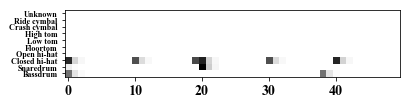

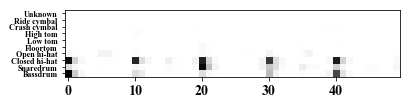

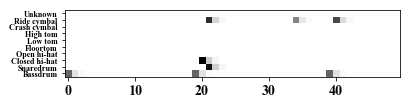

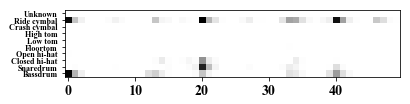

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [25]:
i,j = 0, 10
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [26]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [27]:
# # min: these pixels are 'always' active
# m = x.min(axis=0)
# plot.multi(m[:30,:,0])

In [28]:
# # mean
# m = x.mean(axis=0)
# plot.single(m[:30,:,0])

## Style transfer

In [29]:
m = 1000
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(450, 10)

In [30]:
# dn = config.plots_dir + 'transformations.pkl'
# io.save(transformations, fn)
# # transformation_extraction.save_to_disk(transformations, dn, v=1)

# fn = config.plots_dir + 'min_transformations.pkl'
# io.save(min_transformations, fn)
# # transformation_extraction.save_to_disk(min_transformations, dn)

In [31]:
fn = config.plots_dir + 'transformations-best_dims.pkl'
best_dims = io.load(fn)
fn = config.plots_dir + 'transformations.pkl'
transformations = io.load(fn)
fn = config.plots_dir + 'min_transformations.pkl'
min_transformations = io.load(fn)

(array([317.,  80.,  69.,  21.,  51.,  67., 102.,  46.,  46., 188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

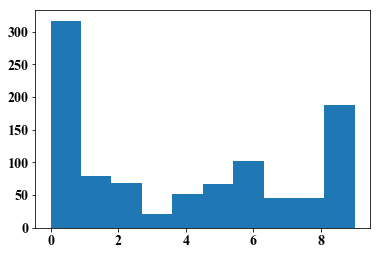

In [32]:
plt.hist(best_dims)

In [33]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [34]:
list(transformations.keys())[:3]

['02 Blues/02 Nappy Brown 160BPM',
 '03 Traditional Pop/04 Love 155BPM',
 '04 Country/07 Trainy 100BPM']

In [35]:
len(transformations.keys())

65

In [36]:
transformations[list(transformations.keys())[0]]

{'07 Indie/05 Halftime 71BPM': array([-0.5490264 ,  0.08678372, -0.0671562 ,  0.01401647,  0.00295448,
         0.07377549, -0.05588749, -0.04529048,  0.02817884, -0.06237605],
       dtype=float32)}

In [77]:
# utils.reload(ncd_evaluation)
grid = [0, 0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 1, 0, -0.01, -0.1, -0.5, -1]
grid = np.linspace(0,1, 21)
grid = np.round(grid, 2)
# grid = (np.logspace(0, 1, 10) -1) / 9
amt1 = 100
grid

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [37]:
different_genre_a = True
result_min = ncd_evaluation.cross(x_train_encoded, genre_dict, min_transformations, 
                                  generator, grid, different_genre_a, amt1=amt1, amt2=1, v=1)


0
original genre: `02 Blues/05 Cadillac 128BPM`
 genre_a `04 Country/07 Trainy 100BPM`

1
original genre: `05 Jazz/04 Silent Tear 234BPM`
 genre_a `01 Rock'n'Roll/06 Moonglow 140BPM`

2
original genre: `02 Blues/02 Nappy Brown 160BPM`
 genre_a `01 Rock'n'Roll/10 Ottis 172bpm`

3
original genre: `06 Soul - Funk/02 Boogaloo 120BPM`
 genre_a `03 Traditional Pop/08 Cecil Cee 101BPM`

4
original genre: `04 Country/04 Snarey 208BPM 3-4`
 genre_a `03 Traditional Pop/08 Cecil Cee 101BPM`

5
original genre: `04 Country/07 Trainy 100BPM`
 genre_a `03 Traditional Pop/09 Distel 155BPM`

6
original genre: `03 Traditional Pop/05 Your Eyes 80BPM`
 genre_a `05 Jazz/08 Neodop 226BPM 3-4`

7
original genre: `05 Jazz/06 Nucleus 172BPM Brushes`
 genre_a `02 Blues/02 Nappy Brown 160BPM`

8
original genre: `05 Jazz/08 Neodop 226BPM 3-4`
 genre_a `03 Traditional Pop/02 Frankies Girl 116BPM`

9
original genre: `04 Country/09 Broonze 122BPM`
 genre_a `03 Traditional Pop/02 Frankies Girl 116BPM`

10
original g


85
original genre: `05 Jazz/09 West Coast 152BPM Brushes`
 genre_a `03 Traditional Pop/07 Lester Lee 133BPM`

86
original genre: `04 Country/03 Straight 72BPM Brushes`
 genre_a `06 Soul - Funk/04 GoGo Soul 100BPM`

87
original genre: `02 Blues/01 Booze 92BPM`
 genre_a `04 Country/05 Brewer 160BPM`

88
original genre: `01 Rock'n'Roll/09 Diddeley 185bpm`
 genre_a `02 Blues/05 Cadillac 128BPM`

89
original genre: `03 Traditional Pop/02 Frankies Girl 116BPM`
 genre_a `01 Rock'n'Roll/09 Diddeley 185bpm`

90
original genre: `03 Traditional Pop/08 Cecil Cee 101BPM`
 genre_a `04 Country/01 Calvin 148BPM`

91
original genre: `05 Jazz/05 TNT 116BPM`
 genre_a `04 Country/02 Marching 94BPM`

92
original genre: `01 Rock'n'Roll/04 Maybelline 233BPM`
 genre_a `04 Country/05 Brewer 160BPM`

93
original genre: `04 Country/08 Eddie Ed 111BPM`
 genre_a `06 Soul - Funk/06 JB Groove 115BPM`

94
original genre: `01 Rock'n'Roll/09 Diddeley 185bpm`
 genre_a `07 Indie/02 Rock Tribal 125BPM`

95
original genre

In [38]:
io.save(result_min, config.plots_dir + 'ncd_evaluation_ABC_min.pkl')

'../results/ncd_evaluation_results.pkl'

In [38]:
result = ncd_evaluation.cross(x_train_encoded, genre_dict, transformations, 
                              generator, grid, different_genre_a, amt1=amt1, amt2=1, v=0)

In [40]:
io.save(result, config.plots_dir + 'ncd_evaluation_ABC.pkl')

'../results/ncd_evaluation_results.pkl'

In [70]:
# utils.reload(ncd_evaluation)
different_genre_a = False
result_AB_min = ncd_evaluation.cross(x_train_encoded, genre_dict, min_transformations, 
                                     generator, grid, different_genre_a, amt1=amt1, amt2=1, v=0)

In [71]:
io.save(result_AB_min, config.plots_dir + 'ncd_evaluation_AB_min.pkl')

'../results/ncd_evaluation_AB_min.pkl'

In [72]:
different_genre_a = False
result_AB = ncd_evaluation.cross(x_train_encoded, genre_dict, transformations, 
                                 generator, grid, different_genre_a, amt1=amt1, amt2=1, v=0)

In [73]:
io.save(result_AB, config.plots_dir + 'ncd_evaluation_AB.pkl')

'../results/ncd_evaluation_AB.pkl'

In [39]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 10)

original


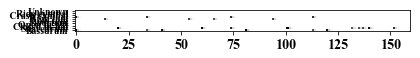

(11, 160, 10, 1) [-0.13435353 -0.05937128  0.00526095 -0.04963645  0.03520458]
identity


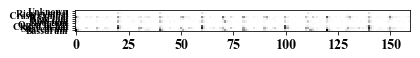

mutations


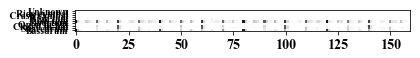

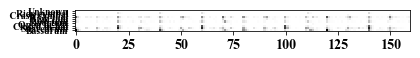

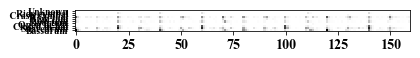

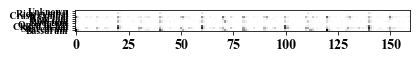

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [40]:
i = 100
amt = 0.3
print('original')
plot.single(x_train[i])
z = encoder.predict(x_train[i:i+1])
zs = [ z[0].copy() for _ in range(latent_dim) ]
for i,z_ in enumerate(zs):
    z_[i] = z_[i] + amt
generated = generator.predict(np.concatenate([z[:1], zs]))
print(generated.shape, z[0,:5])
print('identity')
plot.single(generated[0]) 
print('mutations')
plot.single(generated[1])
plot.single(generated[2])
plot.single(generated[3])
plot.single(generated[4])

In [41]:
mido.MidiFile()

<midi file None type 1, 0 tracks, 0 messages>

In [42]:
# utils.clear_dir(config.export_dir)
for i, sample in enumerate(generated):
    s = midi.MultiTrack.from_array(sample)
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'generated-' + str(i))

 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.7802083333333334
 |  4.0


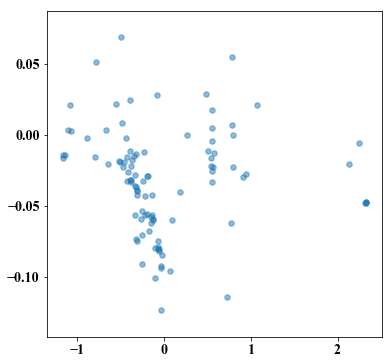

In [43]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

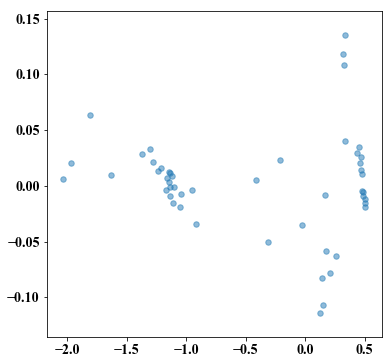

In [44]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [45]:
# x_decoded[0].reshape(150,3)

In [46]:
x_train.shape

(450, 160, 10, 1)

In [47]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

AttributeError: module 'utils.plot' has no attribute 'latent'

In [ ]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,            
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)

In [ ]:
a = [0,11,100,399]
# utils.clear_dir(config.export_dir)
for i in a:
    s = midi.MultiTrack.from_array(x_train[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_true_' + str(i))
    
    s = midi.MultiTrack.from_array(y[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_pred' + str(i))    

# Style transfer
rock ~ funk

In [ ]:
[(a,b) for a,b in enumerate(labels)]

In [ ]:
i,j,k = 21, 140, 105 # 210, 79
m = 80
sample_size = 10
print(labels[i], labels[j], labels[k])
plot.single(x_train[i,:m])
plot.single(x_train[j,:m])
plot.single(x_train[k,:m])

In [ ]:
latent_vectors = encoder.predict(x_train[:250])
indices = np.arange(latent_vectors.shape[-1]) + 1
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + i])
# plt.ylim((-1,1))

In [ ]:
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + j])
# plt.ylim((-1,1))

In [ ]:
indices = np.arange(latent_vectors.shape[-1]) + 1
for l in range(100):
    plt.plot(indices, latent_vectors[l + i])
# plt.ylim((-1,1))

In [ ]:
a = x_train[i:i+sample_size]
b = x_train[j:j+sample_size]
c = x_train[k:k+sample_size]

In [ ]:
t = models.extract_transformation(encoder, a, b)
t

In [ ]:
c_ = models.transfer_style(encoder, generator, a, b, c)
plot.single(c[0,:m])
plot.single(c_[0,:m])

In [ ]:
d = {'original':c, 'generated':c_, 'a':a, 'b':b}
for name,v in d.items():
    mid = midi.decode.track(context, v[0], name=name)
    mid.tracks[0].name = name
    io.export_midifile(mid, config.export_dir + 'style_transfer-' + name)

In [ ]:
from sklearn.decomposition import PCA
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009,
# depending on the shape of the input data and the number of components to extract.

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(latent_vectors)
pca_result.shape

In [ ]:
[round(v,3) for v in pca.explained_variance_ratio_], round(sum(pca.explained_variance_ratio_[:2]),2)

In [ ]:
pca.components_

In [ ]:
pca.singular_values_

In [ ]:
print('2 best dims')
plt.scatter(pca_result[:,0], pca_result[:,1], alpha=0.3, s=10) # c=labels
# plt.ylim((-1,1))

In [ ]:
print('2 best dims, 3 classes')
for i_ in [i,j,k]:
    plt.scatter(pca_result[i_:i_+sample_size,0], pca_result[i_:i_+sample_size,1], alpha=0.6, s=10) # c=labels
# plt.ylim((-1,1))

In [ ]:
# import ggplot
# chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
#         + geom_point(size=75,alpha=0.8) \
#         + ggtitle("First and Second Principal Components colored by digit")
# chart

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)

In [ ]:
# TODO shuffle data?
tsne_results = tsne.fit_transform(latent_vectors)
tsne_results.shape

In [ ]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5, s=10)

In [ ]:
for i_ in [i,j,k]:
    plt.scatter(tsne_results[i_:i_+sample_size,0], tsne_results[i_:i_+sample_size,1], alpha=0.6, s=10) # c=labels
# plt.ylim((-1,1))

In [ ]:
# http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html#sphx-glr-auto-examples-plot-compare-reduction-py
    
# Authors: Robert McGibbon, Joel Nothman, Guillaume Lemaitre

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

In [ ]:
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 8]
C_OPTIONS = [1, 10, 100, 1000]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

In [ ]:
# grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
# digits = load_digits()
# grid.fit(digits.data, digits.target)

In [ ]:
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
